In [39]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import io, color
import cv2
import tensorflow as tf
from keras_segmentation.models.model_utils import get_segmentation_model
from keras_segmentation.models.unet import vgg_unet
from keras_segmentation.predict import predict

In [2]:
import sys
print(sys.version)

3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [4]:
# load in dataset
# df = pd.read_pickle('../Data/training.pkl')
# df.info()

In [52]:
# visualize a training sample, i, with the segmentation mask overlayed
i = 15000
test = np.dstack((df['r_xpl'][i], df['g_xpl'][i], df['b_xpl'][i]))
io.imshow(color.label2rgb(df['labels'][i], test ))

NameError: name 'df' is not defined

In [58]:
test = np.array(Image.open('../dataset/train_segmentation/img_1.png'))
np.unique(test)

array([0, 1, 2, 3, 4, 5, 6], dtype=uint8)

In [59]:
input_height=200
input_width=200
img_input = tf.keras.Input(shape=(input_height, input_width, 3))

n_classes = 7


In [60]:
# define encoder layers
# conv1 and conv2 contain intermediate the encoder outputs
# which will be used by the decoder
# pool2 is the final output of the encoder

# two convolution layers and one pooling layer, which downsamples image by a factor of 2
conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
conv1 = tf.keras.layers.Dropout(0.2)(conv1)
conv1 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(conv1)
pool1 = tf.keras.layers.MaxPooling2D((2,2))(conv1)

conv2 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(pool1)
conv2 = tf.keras.layers.Dropout(0.2)(conv2)
conv2 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv2)
pool2 = tf.keras.layers.MaxPooling2D((2,2))(conv2)

# decoder layers
conv3 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(pool2)
conv3 = tf.keras.layers.Dropout(0.2)(conv3)
conv3 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv3)

# concat intermediate encoder outputs with intermediate decoder outputs, which is the skip connection
up1 = tf.keras.layers.concatenate([tf.keras.layers.UpSampling2D((2,2))(conv3), conv2], axis=-1)
conv4 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(up1)
conv4 = tf.keras.layers.Dropout(0.2)(conv4)
conv4 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv4)

up2 = tf.keras.layers.concatenate([tf.keras.layers.UpSampling2D((2,2))(conv4), conv1], axis=-1)
conv5 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(up2)
conv5 = tf.keras.layers.Dropout(0.2)(conv5)
conv5 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(conv5)

# get output with proper number of classes
out = tf.keras.layers.Conv2D(n_classes, (1,1), padding='same')(conv5)

In [41]:
unet_model = vgg_unet(n_classes=7, input_height=320, input_width=320)

58892288/58889256 [==============================] - 10s 0us/step


In [42]:
unet_model.train(
    train_images = '../dataset/train_images/',
    train_annotations = '../dataset/train_segmentation/',
    checkpoints_path = '../dataset/unet_checkpoints/vgg_unet_1',
    epochs = 5)

Verifying training dataset


100%|██████████| 13000/13000 [00:45<00:00, 285.13it/s]


Dataset verified! 
Epoch 1/5
512/512 [==============================] - 1535s 3s/step - loss: 2.4553 - accuracy: 0.1149
saved  ../dataset/unet_checkpoints/vgg_unet_1.0
Epoch 2/5
512/512 [==============================] - 1668s 3s/step - loss: 2.2059 - accuracy: 0.2483
saved  ../dataset/unet_checkpoints/vgg_unet_1.1
Epoch 3/5
512/512 [==============================] - 1788s 3s/step - loss: 2.0624 - accuracy: 0.3213
saved  ../dataset/unet_checkpoints/vgg_unet_1.2
Epoch 4/5
512/512 [==============================] - 1840s 4s/step - loss: 1.9974 - accuracy: 0.3568
saved  ../dataset/unet_checkpoints/vgg_unet_1.3
Epoch 5/5
512/512 [==============================] - 1524s 3s/step - loss: 1.9374 - accuracy: 0.3521
saved  ../dataset/unet_checkpoints/vgg_unet_1.4


In [61]:
# custom model
model = get_segmentation_model(img_input, out)
model.train(
    train_images = '../dataset/train_images/',
    train_annotations = '../dataset/train_segmentation/',
    checkpoints_path = '../dataset/custom_checkpoints/custom_net',
    epochs = 10)

Verifying training dataset


100%|██████████| 13000/13000 [00:46<00:00, 278.35it/s]


Dataset verified! 
Epoch 1/10
512/512 [==============================] - 430s 839ms/step - loss: 4.3978 - accuracy: 0.2637
saved  ../dataset/custom_checkpoints/custom_net.0
Epoch 2/10
512/512 [==============================] - 415s 811ms/step - loss: 2.2910 - accuracy: 0.4212
saved  ../dataset/custom_checkpoints/custom_net.1
Epoch 3/10
512/512 [==============================] - 424s 827ms/step - loss: 1.6969 - accuracy: 0.4354
saved  ../dataset/custom_checkpoints/custom_net.2
Epoch 4/10
512/512 [==============================] - 464s 907ms/step - loss: 1.4798 - accuracy: 0.4695
saved  ../dataset/custom_checkpoints/custom_net.3
Epoch 5/10
512/512 [==============================] - 460s 899ms/step - loss: 1.4251 - accuracy: 0.4829
saved  ../dataset/custom_checkpoints/custom_net.4
Epoch 6/10
512/512 [==============================] - 427s 833ms/step - loss: 1.3477 - accuracy: 0.5072
saved  ../dataset/custom_checkpoints/custom_net.5
Epoch 7/10
512/512 [==============================] - 575

# look at model results

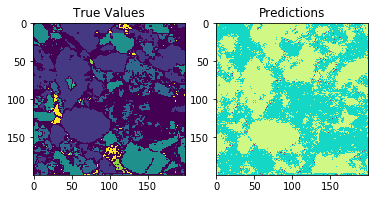

In [87]:
# self made model
i = 13200
# get prediction on test set
out = model.predict_segmentation(
    inp = f'../dataset/val_images/img_{i}.png',
    out_fname = 'output.png')

# load the test image
pred_img = Image.open('output.png').convert('RGB')

# load original image
orig_img = Image.open(f'../dataset/val_segmentation/img_{i}.png')

plt.subplot(1,2,1)
plt.title('True Values')
plt.imshow(orig_img)

plt.subplot(1,2,2)
plt.title('Predictions')
plt.imshow(pred_img)

accuracy ~53%

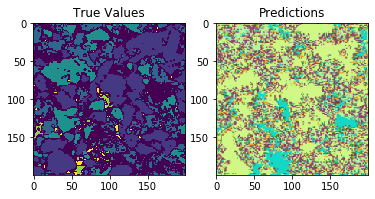

In [85]:
#vgg_unet results
i = 13120
# get prediction on test set
out = unet_model.predict_segmentation(
    inp = f'../dataset/val_images/img_{i}.png',
    out_fname = 'output.png')

# load the test image
pred_img = Image.open('output.png').convert('RGB')

# load original image
orig_img = Image.open(f'../dataset/val_segmentation/img_{i}.png')

plt.subplot(1,2,1)
plt.title('True Values')
plt.imshow(orig_img)

plt.subplot(1,2,2)
plt.title('Predictions')
plt.imshow(pred_img)

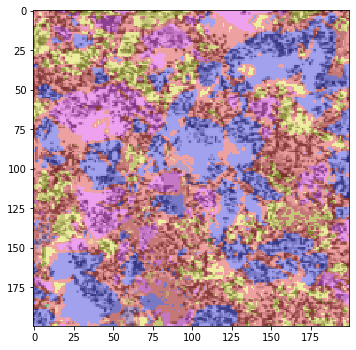

In [86]:
# show segmentated labels on the original image
plt.figure(figsize=(5, 5))
io.imshow(color.label2rgb(np.array(orig_img), np.array(pred_img)))

accuracy ~35%

In [71]:
# unique, counts = np.unique(np.array(test_img), axis = 0, return_counts=True)

# #frequencies = np.asarray((unique, counts))

# print(unique)